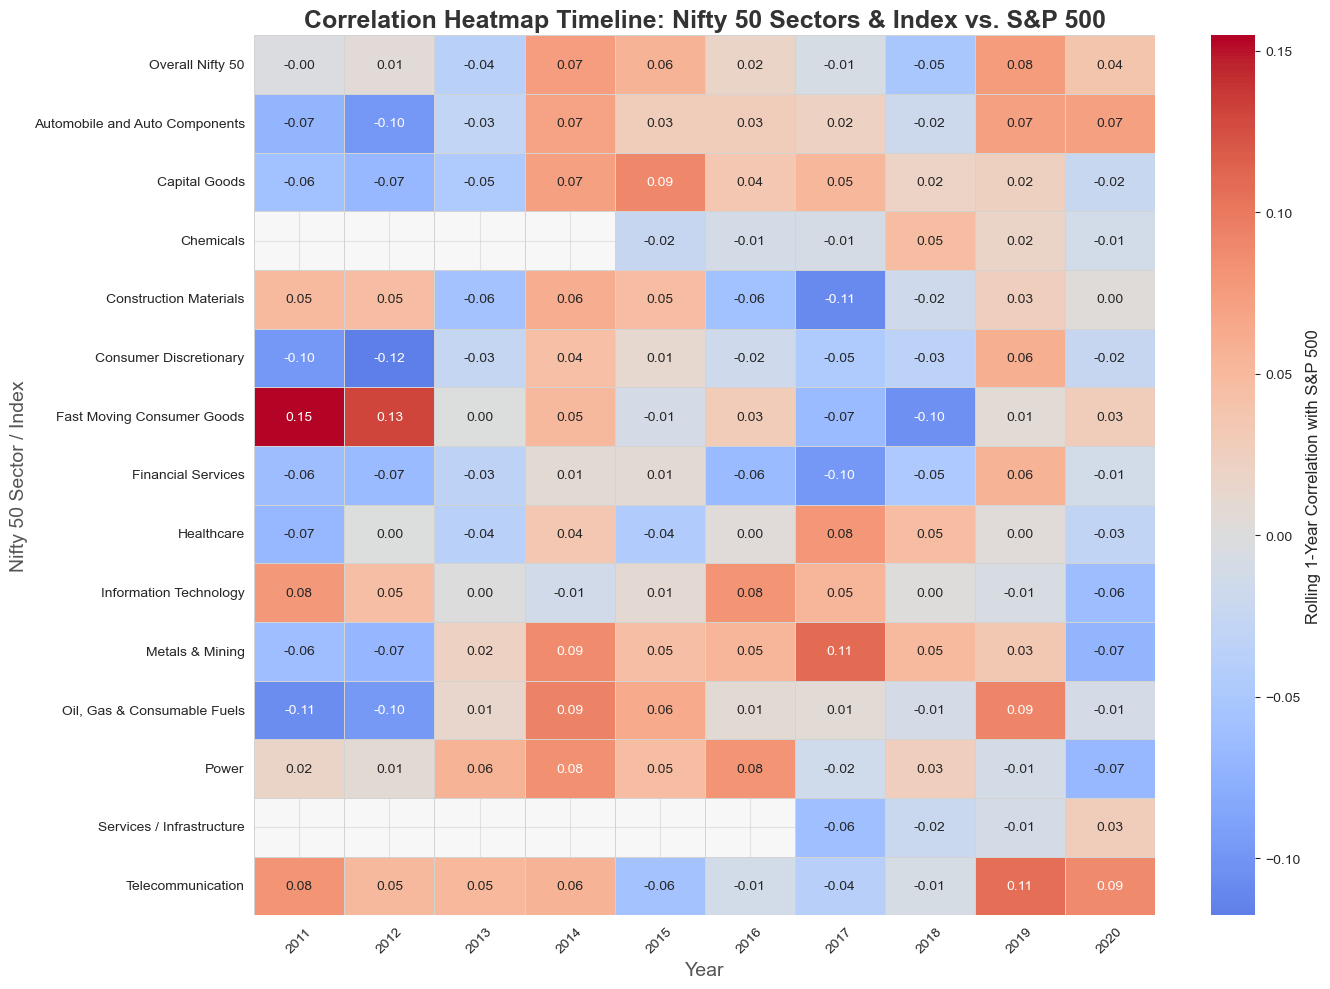

Correlation Heatmap Timeline chart generated and saved as 'nifty50_sp500_correlation_heatmap_timeline.png'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv' and 'Final-50-stocks.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
# Add fill_method=None to suppress FutureWarning
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change(fill_method=None).dropna()

# Nifty 50 Stocks Data: Calculate individual stock returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

# --- FIX: Calculate Nifty50_Proxy_Close before using it ---
nifty50_stocks_df['Nifty50_Proxy_Close'] = nifty50_stocks_df[stock_tickers].mean(axis=1)

# Add fill_method=None to suppress FutureWarning
nifty50_stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change(fill_method=None).dropna(how='all')

# Nifty 50 Proxy Data: Calculate a proxy for Nifty 50 Index returns
# Now Nifty50_Proxy_Close exists in nifty50_stocks_df
nifty50_proxy_df = nifty50_stocks_df[['Nifty50_Proxy_Close']].copy()
nifty50_proxy_df.columns = ['Nifty50_Close']
# Add fill_method=None to suppress FutureWarning
nifty50_proxy_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Close'].pct_change(fill_method=None).dropna()


# --- Define Sector Mapping (reusing from previous questions) ---
sector_mapping = {
    'TATASTEEL': 'Metals & Mining', 'WIPRO': 'Information Technology', 'TITAN': 'Consumer Discretionary',
    'ULTRACEMO': 'Construction Materials', 'TECHM': 'Information Technology', 'RELIANCE': 'Oil, Gas & Consumable Fuels',
    'SHREECEM': 'Construction Materials', 'SUNPHARMA': 'Healthcare', 'TATAMOTORS': 'Automobile and Auto Components',
    'TCS': 'Information Technology', 'SBIN': 'Financial Services', 'NESTLEIND': 'Fast Moving Consumer Goods',
    'NTPC': 'Power', 'M&M': 'Automobile and Auto Components', 'MARUTI': 'Automobile and Auto Components',
    'ONGC': 'Oil, Gas & Consumable Fuels', 'POWERGRID': 'Power', 'JSWSTEEL': 'Metals & Mining',
    'KOTAKBANK': 'Financial Services', 'LT': 'Capital Goods', 'ICICIBANK': 'Financial Services',
    'INDUSBANK': 'Financial Services', 'INFY': 'Information Technology', 'IOC': 'Oil, Gas & Consumable Fuels',
    'ITC': 'Fast Moving Consumer Goods', 'HEROMOTOCO': 'Automobile and Auto Components', 'HINDALCO': 'Metals & Mining',
    'HINDUNILVR': 'Fast Moving Consumer Goods', 'HCLTECH': 'Information Technology', 'HDFCBANK': 'Financial Services',
    'HDFC': 'Financial Services', 'DRREDDYS': 'Healthcare', 'EICHERMOTOR': 'Automobile and Auto Components',
    'GRASIM': 'Construction Materials', 'CIPLA': 'Healthcare', 'COALINDIA': 'Oil, Gas & Consumable Fuels',
    'BPCL': 'Oil, Gas & Consumable Fuels', 'BRITANNIA': 'Fast Moving Consumer Goods',
    'ADANIPORTS': 'Services / Infrastructure', 'BAJAJFINSERV': 'Financial Services',
    'BAJAJFINANCE': 'Financial Services', 'BHARTIARTL': 'Telecommunication', 'AXISBANK': 'Financial Services',
    'BAJAJ-AUTO': 'Automobile and Auto Components', 'ASIANPAINT': 'Consumer Discretionary', 'UPL': 'Chemicals'
}

# Aggregate stock returns by sector
stock_returns_melted = nifty50_stock_returns_df.reset_index().melt(id_vars='Date', var_name='Stock', value_name='Daily_Return')
stock_returns_melted['Sector'] = stock_returns_melted['Stock'].map(sector_mapping)
stock_returns_melted = stock_returns_melted.dropna(subset=['Sector']) # Drop stocks not mapped to a sector

sector_avg_daily_returns = stock_returns_melted.groupby(['Date', 'Sector'])['Daily_Return'].mean().unstack()
sector_avg_daily_returns = sector_avg_daily_returns.dropna(how='all') # Drop dates where all sectors are NaN

# Combine Nifty 50 Proxy returns and Sector returns
all_indian_returns_df = pd.concat([
    nifty50_proxy_df['Nifty50_Returns'].rename('Overall Nifty 50'), # Add overall Nifty 50
    sector_avg_daily_returns
], axis=1).dropna(how='all') # Drop any rows where all are NaN after concat

# --- Align all dataframes to a common date range ---
common_start_date = max(all_indian_returns_df.index.min(), sp500_df.index.min())
common_end_date = min(all_indian_returns_df.index.max(), sp500_df.index.max())

# Filter all dataframes to the common date range
all_indian_returns_aligned = all_indian_returns_df.loc[common_start_date:common_end_date]
sp500_returns_aligned = sp500_df['SP500_Returns'].loc[common_start_date:common_end_date]

# --- 3. Calculate Rolling Correlations ---
# Define rolling window (e.g., 1 year = 252 trading days)
rolling_window = 252 # Approximately 1 year of trading days

# Prepare a DataFrame to store rolling correlations
rolling_correlations = pd.DataFrame()

# Iterate through each Nifty 50 sector (and overall Nifty 50 proxy)
for col in all_indian_returns_aligned.columns:
    # Combine the sector's returns with S&P 500 returns for rolling correlation
    temp_combined = pd.DataFrame({
        'Nifty_Returns': all_indian_returns_aligned[col],
        'SP500_Returns': sp500_returns_aligned
    }).dropna() # Drop NaNs for the rolling calculation

    # Calculate rolling correlation
    # min_periods ensures we only get a correlation if enough data points are present in the window
    rolling_corr = temp_combined['Nifty_Returns'].rolling(window=rolling_window, min_periods=rolling_window).corr(temp_combined['SP500_Returns'])
    rolling_correlations[col] = rolling_corr

# Drop any rows (dates) where all rolling correlations are NaN (typically at the beginning)
rolling_correlations = rolling_correlations.dropna(how='all')

# --- Prepare data for Heatmap Timeline ---
# Resample rolling correlations to a coarser time unit (e.g., quarterly or yearly) for heatmap columns
# Use 'YE' for Year End and string "prod" for apply to suppress FutureWarning
correlation_heatmap_data = rolling_correlations.resample('YE').mean()
correlation_heatmap_data.index = correlation_heatmap_data.index.year # Use just the year for column names

# Transpose for heatmap: sectors as rows, years as columns
correlation_heatmap_data = correlation_heatmap_data.T

# --- 4. Visualization: Correlation Heatmap Timeline ---

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

fig, ax = plt.subplots(figsize=(14, 10)) # Adjust size for readability

sns.heatmap(
    correlation_heatmap_data,
    annot=True, # Show correlation values in cells
    fmt=".2f", # Format to two decimal places
    cmap='coolwarm', # Diverging colormap: blue (positive) to red (negative)
    center=0, # Center the colormap at 0 correlation
    linewidths=.5, # Lines between cells
    linecolor='lightgray',
    cbar_kws={'label': 'Rolling 1-Year Correlation with S&P 500'}
)

ax.set_title('Correlation Heatmap Timeline: Nifty 50 Sectors & Index vs. S&P 500', fontsize=18, fontweight='bold', color='#333333')
ax.set_xlabel('Year', fontsize=14, color='#555555')
ax.set_ylabel('Nifty 50 Sector / Index', fontsize=14, color='#555555')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('nifty50_sp500_correlation_heatmap_timeline.png')
plt.show()
plt.close(fig)

print("Correlation Heatmap Timeline chart generated and saved as 'nifty50_sp500_correlation_heatmap_timeline.png'")


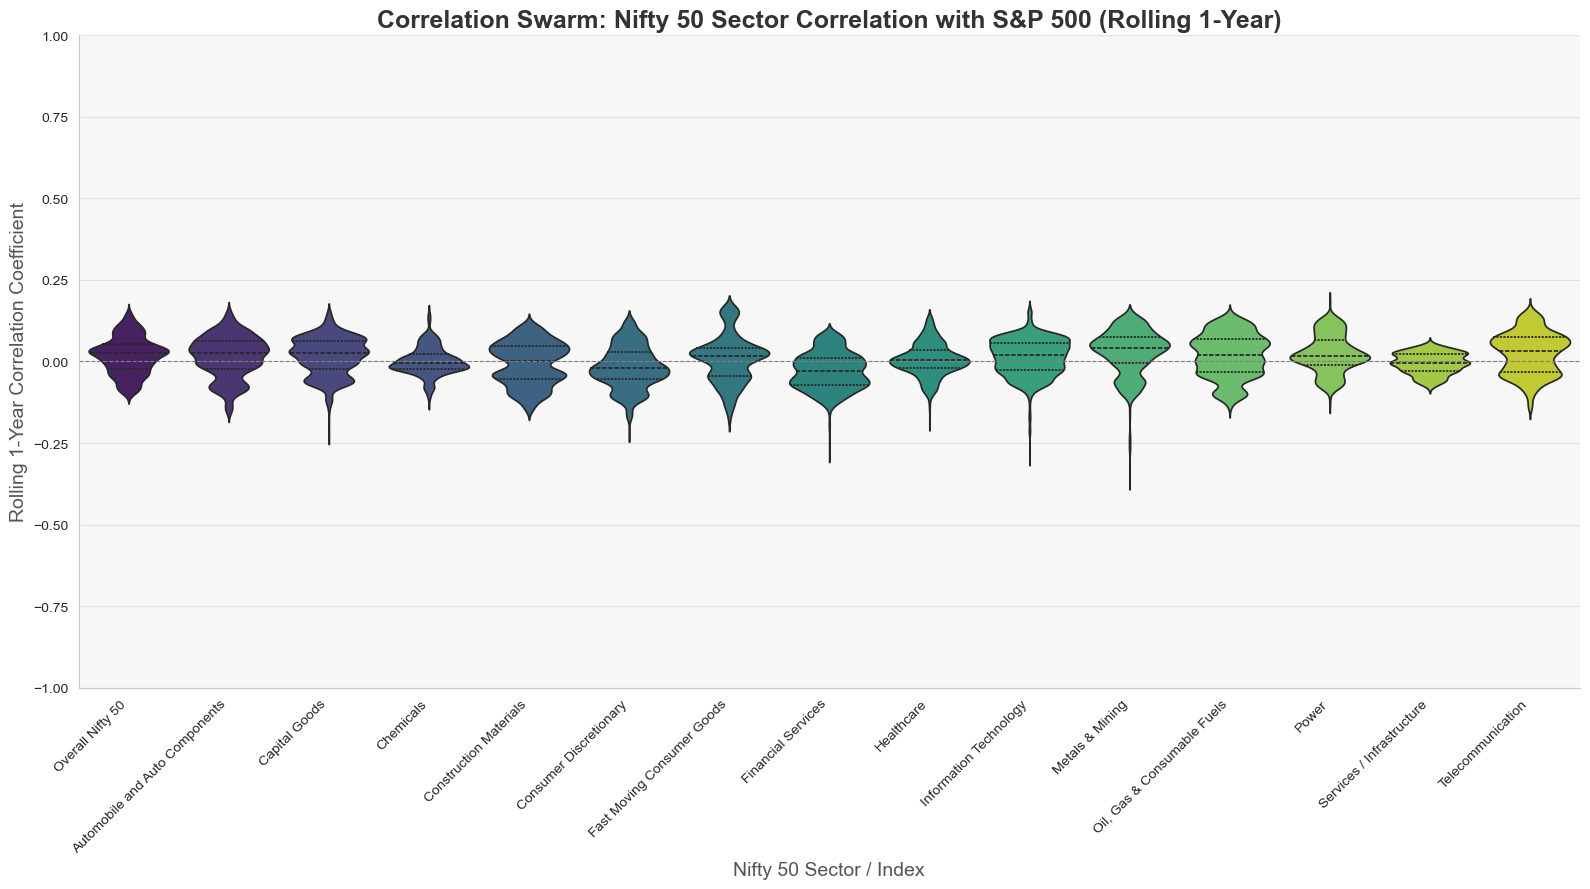

Correlation Swarm Plot generated and saved as 'nifty50_sp500_correlation_swarm_plot.png'


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
try:
    sp500_df = pd.read_csv('SPX.csv', parse_dates=['Date'])
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'SPX.csv' and 'Final-50-stocks.csv' are in the same directory as this script.")
    print("Please ensure the files are correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Data Preprocessing ---

# S&P 500 Data: Select 'Date' and 'Adj Close' and calculate returns
sp500_df = sp500_df[['Date', 'Adj Close']].copy()
sp500_df.columns = ['Date', 'SP500_Close']
sp500_df = sp500_df.sort_values(by='Date').set_index('Date')
# Add fill_method=None to suppress FutureWarning
sp500_df['SP500_Returns'] = sp500_df['SP500_Close'].pct_change(fill_method=None).dropna()

# Nifty 50 Stocks Data: Calculate individual stock returns
nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
if 'Date' in stock_tickers:
    stock_tickers.remove('Date')

for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

# --- FIX: Calculate Nifty50_Proxy_Close before using it ---
nifty50_stocks_df['Nifty50_Proxy_Close'] = nifty50_stocks_df[stock_tickers].mean(axis=1)

# Add fill_method=None to suppress FutureWarning
nifty50_stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change(fill_method=None).dropna(how='all')

# Nifty 50 Proxy Data: Calculate a proxy for Nifty 50 Index returns
# Now Nifty50_Proxy_Close exists in nifty50_stocks_df
nifty50_proxy_df = nifty50_stocks_df[['Nifty50_Proxy_Close']].copy()
nifty50_proxy_df.columns = ['Nifty50_Close']
# Add fill_method=None to suppress FutureWarning
nifty50_proxy_df['Nifty50_Returns'] = nifty50_proxy_df['Nifty50_Close'].pct_change(fill_method=None).dropna()


# --- Define Sector Mapping (reusing from previous questions) ---
sector_mapping = {
    'TATASTEEL': 'Metals & Mining', 'WIPRO': 'Information Technology', 'TITAN': 'Consumer Discretionary',
    'ULTRACEMO': 'Construction Materials', 'TECHM': 'Information Technology', 'RELIANCE': 'Oil, Gas & Consumable Fuels',
    'SHREECEM': 'Construction Materials', 'SUNPHARMA': 'Healthcare', 'TATAMOTORS': 'Automobile and Auto Components',
    'TCS': 'Information Technology', 'SBIN': 'Financial Services', 'NESTLEIND': 'Fast Moving Consumer Goods',
    'NTPC': 'Power', 'M&M': 'Automobile and Auto Components', 'MARUTI': 'Automobile and Auto Components',
    'ONGC': 'Oil, Gas & Consumable Fuels', 'POWERGRID': 'Power', 'JSWSTEEL': 'Metals & Mining',
    'KOTAKBANK': 'Financial Services', 'LT': 'Capital Goods', 'ICICIBANK': 'Financial Services',
    'INDUSBANK': 'Financial Services', 'INFY': 'Information Technology', 'IOC': 'Oil, Gas & Consumable Fuels',
    'ITC': 'Fast Moving Consumer Goods', 'HEROMOTOCO': 'Automobile and Auto Components', 'HINDALCO': 'Metals & Mining',
    'HINDUNILVR': 'Fast Moving Consumer Goods', 'HCLTECH': 'Information Technology', 'HDFCBANK': 'Financial Services',
    'HDFC': 'Financial Services', 'DRREDDYS': 'Healthcare', 'EICHERMOTOR': 'Automobile and Auto Components',
    'GRASIM': 'Construction Materials', 'CIPLA': 'Healthcare', 'COALINDIA': 'Oil, Gas & Consumable Fuels',
    'BPCL': 'Oil, Gas & Consumable Fuels', 'BRITANNIA': 'Fast Moving Consumer Goods',
    'ADANIPORTS': 'Services / Infrastructure', 'BAJAJFINSERV': 'Financial Services',
    'BAJAJFINANCE': 'Financial Services', 'BHARTIARTL': 'Telecommunication', 'AXISBANK': 'Financial Services',
    'BAJAJ-AUTO': 'Automobile and Auto Components', 'ASIANPAINT': 'Consumer Discretionary', 'UPL': 'Chemicals'
}

# Aggregate stock returns by sector
stock_returns_melted = nifty50_stock_returns_df.reset_index().melt(id_vars='Date', var_name='Stock', value_name='Daily_Return')
stock_returns_melted['Sector'] = stock_returns_melted['Stock'].map(sector_mapping)
stock_returns_melted = stock_returns_melted.dropna(subset=['Sector']) # Drop stocks not mapped to a sector

sector_avg_daily_returns = stock_returns_melted.groupby(['Date', 'Sector'])['Daily_Return'].mean().unstack()
sector_avg_daily_returns = sector_avg_daily_returns.dropna(how='all') # Drop dates where all sectors are NaN

# Combine Nifty 50 Proxy returns and Sector returns
all_indian_returns_df = pd.concat([
    nifty50_proxy_df['Nifty50_Returns'].rename('Overall Nifty 50'), # Add overall Nifty 50
    sector_avg_daily_returns
], axis=1).dropna(how='all') # Drop any rows where all are NaN after concat

# --- Align all dataframes to a common date range ---
common_start_date = max(all_indian_returns_df.index.min(), sp500_df.index.min())
common_end_date = min(all_indian_returns_df.index.max(), sp500_df.index.max())

# Filter all dataframes to the common date range
all_indian_returns_aligned = all_indian_returns_df.loc[common_start_date:common_end_date]
sp500_returns_aligned = sp500_df['SP500_Returns'].loc[common_start_date:common_end_date]

# --- 3. Calculate Rolling Correlations ---
# Define rolling window (e.g., 1 year = 252 trading days)
rolling_window = 252 # Approximately 1 year of trading days

# Prepare a DataFrame to store rolling correlations
rolling_correlations = pd.DataFrame()

# Iterate through each Nifty 50 sector (and overall Nifty 50 proxy)
for col in all_indian_returns_aligned.columns:
    # Combine the sector's returns with S&P 500 returns for rolling correlation
    temp_combined = pd.DataFrame({
        'Nifty_Returns': all_indian_returns_aligned[col],
        'SP500_Returns': sp500_returns_aligned
    }).dropna() # Drop NaNs for the rolling calculation

    # Calculate rolling correlation
    # min_periods ensures we only get a correlation if enough data points are present in the window
    rolling_corr = temp_combined['Nifty_Returns'].rolling(window=rolling_window, min_periods=rolling_window).corr(temp_combined['SP500_Returns'])
    rolling_correlations[col] = rolling_corr

# Drop any rows (dates) where all rolling correlations are NaN (typically at the beginning)
rolling_correlations = rolling_correlations.dropna(how='all')

# --- Prepare data for Violin Plot ---
# Melt the rolling_correlations DataFrame to long format for seaborn violinplot
rolling_correlations_melted = rolling_correlations.melt(var_name='Nifty Sector / Index', value_name='Rolling Correlation with S&P 500').dropna()


# --- 4. Visualization: Correlation Swarm Plot (Violin Plot) ---

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

fig, ax = plt.subplots(figsize=(16, 9)) # Wider figure to accommodate many sectors

sns.violinplot(
    data=rolling_correlations_melted,
    x='Nifty Sector / Index',
    y='Rolling Correlation with S&P 500',
    hue='Nifty Sector / Index', # FIX: Assign x to hue to resolve FutureWarning
    inner='quartile', # Show quartiles inside the violins
    palette='viridis', # A nice color palette
    ax=ax,
    legend=False # FIX: Set legend to False as hue is assigned to x
)

ax.set_title('Correlation Swarm: Nifty 50 Sector Correlation with S&P 500 (Rolling 1-Year)', fontsize=18, fontweight='bold', color='#333333')
ax.set_xlabel('Nifty 50 Sector / Index', fontsize=14, color='#555555')
ax.set_ylabel('Rolling 1-Year Correlation Coefficient', fontsize=14, color='#555555')
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Line at 0 correlation

# Rotate x-axis labels for readability if many sectors
plt.xticks(rotation=45, ha='right')

# Set y-axis limits for correlation (always -1 to 1)
ax.set_ylim([-1, 1])

plt.tight_layout()
plt.savefig('nifty50_sp500_correlation_swarm_plot.png')
plt.show()
plt.close(fig)

print("Correlation Swarm Plot generated and saved as 'nifty50_sp500_correlation_swarm_plot.png'")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\1283373515.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\1283373515.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\1283373515.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\1283373515.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

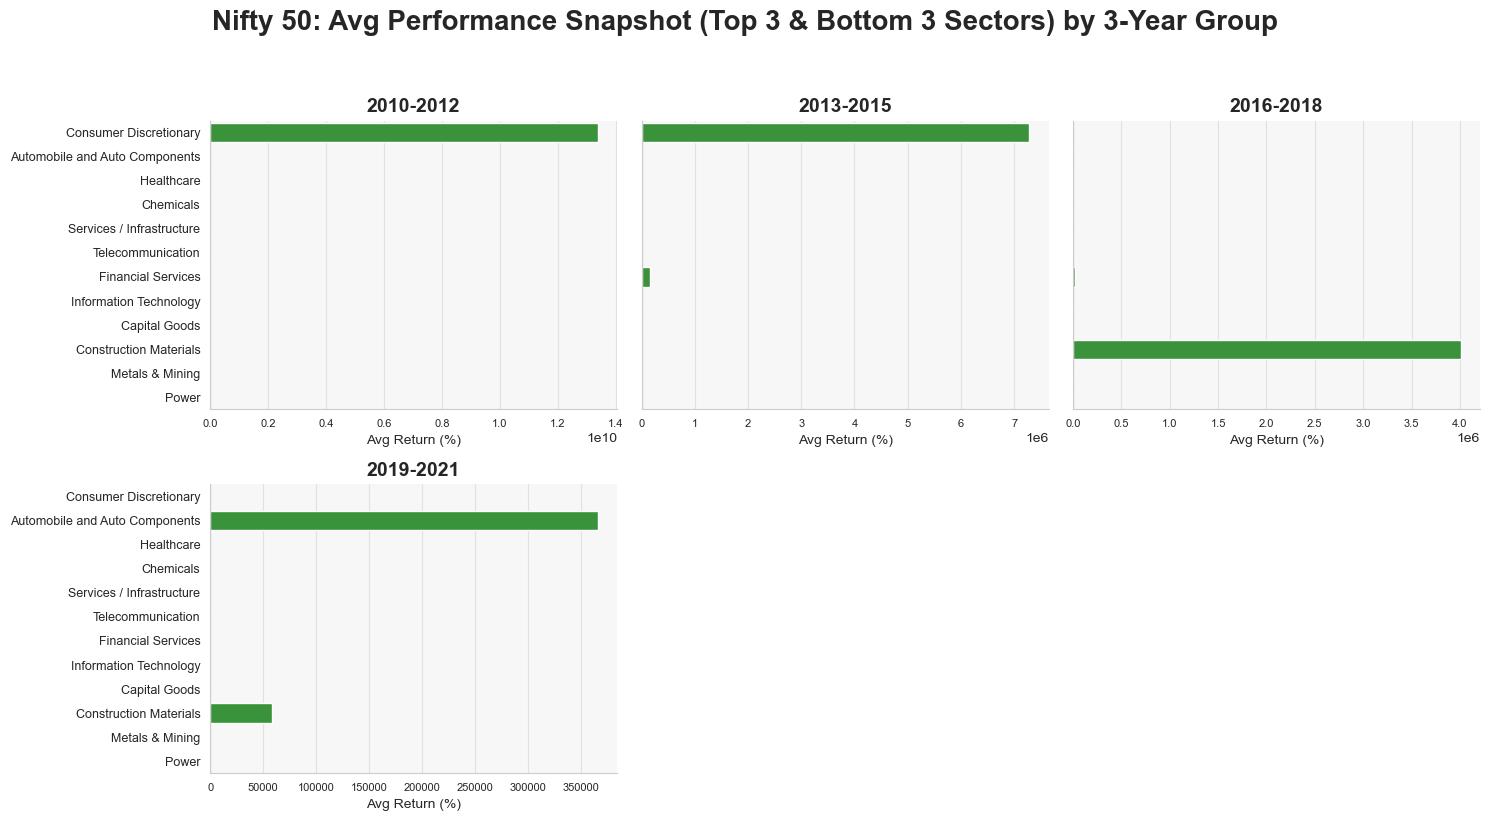

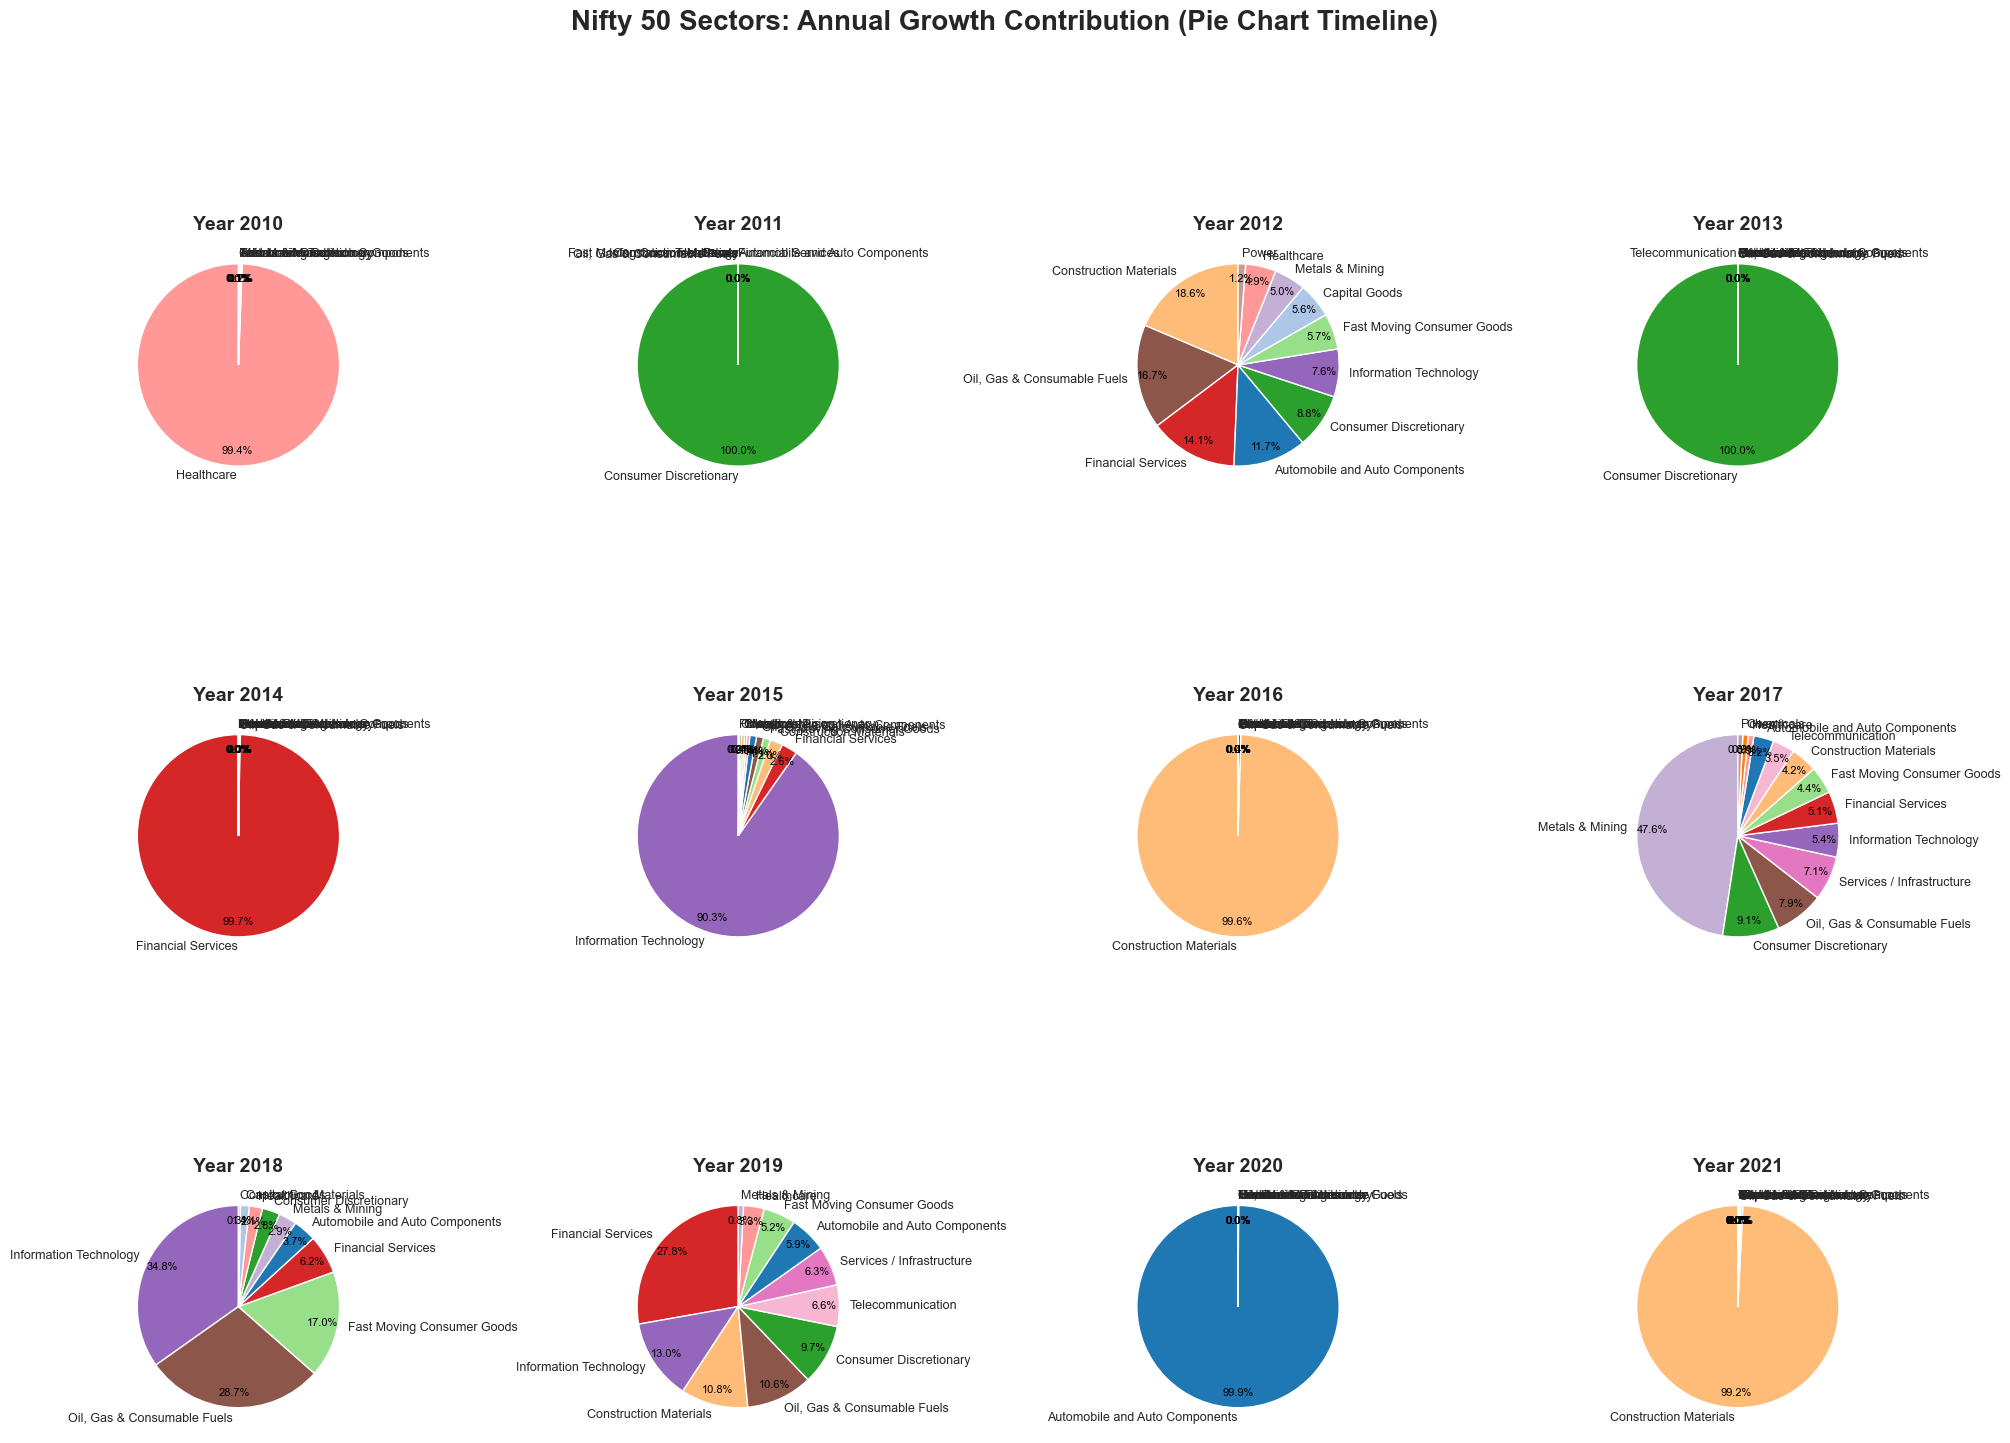

Nifty 50 Sector Growth Analysis charts generated and saved.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---
try:
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'Final-50-stocks.csv' is in the same directory as this script.")
    print("Please ensure the file is correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Define Sector Mapping ---
sector_mapping = {
    'TATASTEEL': 'Metals & Mining', 'WIPRO': 'Information Technology', 'TITAN': 'Consumer Discretionary',
    'ULTRACEMO': 'Construction Materials', 'TECHM': 'Information Technology', 'RELIANCE': 'Oil, Gas & Consumable Fuels',
    'SHREECEM': 'Construction Materials', 'SUNPHARMA': 'Healthcare', 'TATAMOTORS': 'Automobile and Auto Components',
    'TCS': 'Information Technology', 'SBIN': 'Financial Services', 'NESTLEIND': 'Fast Moving Consumer Goods',
    'NTPC': 'Power', 'M&M': 'Automobile and Auto Components', 'MARUTI': 'Automobile and Auto Components',
    'ONGC': 'Oil, Gas & Consumable Fuels', 'POWERGRID': 'Power', 'JSWSTEEL': 'Metals & Mining',
    'KOTAKBANK': 'Financial Services', 'LT': 'Capital Goods', 'ICICIBANK': 'Financial Services',
    'INDUSBANK': 'Financial Services', 'INFY': 'Information Technology', 'IOC': 'Oil, Gas & Consumable Fuels',
    'ITC': 'Fast Moving Consumer Goods', 'HEROMOTOCO': 'Automobile and Auto Components', 'HINDALCO': 'Metals & Mining',
    'HINDUNILVR': 'Fast Moving Consumer Goods', 'HCLTECH': 'Information Technology', 'HDFCBANK': 'Financial Services',
    'HDFC': 'Financial Services', 'DRREDDYS': 'Healthcare', 'EICHERMOTOR': 'Automobile and Auto Components',
    'GRASIM': 'Construction Materials', 'CIPLA': 'Healthcare', 'COALINDIA': 'Oil, Gas & Consumable Fuels',
    'BPCL': 'Oil, Gas & Consumable Fuels', 'BRITANNIA': 'Fast Moving Consumer Goods',
    'ADANIPORTS': 'Services / Infrastructure', 'BAJAJFINSERV': 'Financial Services',
    'BAJAJFINANCE': 'Financial Services', 'BHARTIARTL': 'Telecommunication', 'AXISBANK': 'Financial Services',
    'BAJAJ-AUTO': 'Automobile and Auto Components', 'ASIANPAINT': 'Consumer Discretionary', 'UPL': 'Chemicals'
}

# --- 3. Data Preprocessing and Sector Aggregation ---

nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df = nifty50_stocks_df.dropna(how='all', subset=stock_tickers)
# Add fill_method=None to suppress FutureWarning
stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change(fill_method=None)

stock_returns_melted = stock_returns_df.reset_index().melt(id_vars='Date', var_name='Stock', value_name='Daily_Return')
stock_returns_melted['Sector'] = stock_returns_melted['Stock'].map(sector_mapping)
stock_returns_melted = stock_returns_melted.dropna(subset=['Sector'])

sector_avg_daily_returns = stock_returns_melted.groupby(['Date', 'Sector'])['Daily_Return'].mean().unstack()
sector_avg_daily_returns = sector_avg_daily_returns.dropna(how='all')

# --- Calculate Annual Returns for Charts ---
# Use 'YE' for Year End and string "prod" for apply to suppress FutureWarning
annual_returns_sectors = (1 + sector_avg_daily_returns).resample('YE').apply("prod") - 1
annual_returns_sectors = annual_returns_sectors * 100 # Convert to percentage
annual_returns_sectors.index = annual_returns_sectors.index.year # Set index to just the year

# Fill NaNs with 0 for plotting (implies no return if data missing for a year)
annual_returns_sectors_filled = annual_returns_sectors.fillna(0)


# --- 4. Visualizations ---

# Set a stylish seaborn theme
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

# Plot 1: Annual Sector Performance Snapshot: Top 3 & Bottom 3 (Grouped by 3 years)
num_top_bottom = 3 # Number of top/bottom sectors to show
group_size = 3 # Number of years to group together

all_years = annual_returns_sectors_filled.index.tolist()
year_groups = []
for i in range(0, len(all_years), group_size):
    year_groups.append(all_years[i:i + group_size])

# Determine grid size for subplots
num_cols_bar_chart = 3 # Let's keep 3 columns for better layout of 3-year groups
num_rows_bar_chart = int(np.ceil(len(year_groups) / num_cols_bar_chart))

fig1, axes1 = plt.subplots(num_rows_bar_chart, num_cols_bar_chart, figsize=(num_cols_bar_chart * 5, num_rows_bar_chart * 4), sharey=True)
axes1 = axes1.flatten()

for i, year_group in enumerate(year_groups):
    ax = axes1[i]
    
    # Calculate average annual return for each sector within this 3-year group
    group_start_year = year_group[0]
    group_end_year = year_group[-1]
    
    # Filter data for the current group of years
    group_data = annual_returns_sectors_filled.loc[group_start_year : group_end_year]
    
    # Calculate the average return for each sector across these years
    avg_group_returns = group_data.mean(axis=0).sort_values(ascending=False)
    
    # Get top N and bottom N sectors based on these average group returns
    top_n = avg_group_returns.head(num_top_bottom)
    bottom_n = avg_group_returns.tail(num_top_bottom)
    
    # Combine and sort for plotting
    plot_data = pd.concat([top_n, bottom_n]).reset_index()
    plot_data.columns = ['Sector', 'Average_Return']
    
    # Define colors: green for positive, red for negative
    colors = ['#2ca02c' if x > 0 else '#d62728' for x in plot_data['Average_Return']]

    sns.barplot(
        x='Average_Return',
        y='Sector',
        data=plot_data,
        palette=colors, # Use custom colors
        ax=ax
    )
    
    ax.set_title(f'{group_start_year}-{group_end_year}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Avg Return (%)', fontsize=10)
    ax.set_ylabel('') # Hide y-label for individual plots
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Zero line

# Remove any unused subplots
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])

plt.suptitle(f'Nifty 50: Avg Performance Snapshot (Top {num_top_bottom} & Bottom {num_top_bottom} Sectors) by {group_size}-Year Group', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f'nifty50_sectors_annual_top_bottom_bar_charts_grouped_by_{group_size}_years.png')
plt.show()
plt.close(fig1)


# Plot 2: Sector Contribution Pie Chart Timeline
# Filter for years with positive overall market return to make pie charts meaningful (contribution to growth)
# This requires calculating overall Nifty 50 annual return
overall_nifty_annual_return = (1 + sector_avg_daily_returns.mean(axis=1)).resample('YE').apply("prod") - 1
overall_nifty_annual_return = overall_nifty_annual_return * 100
overall_nifty_annual_return.index = overall_nifty_annual_return.index.year

years_with_positive_overall_return = overall_nifty_annual_return[overall_nifty_annual_return > 0].index.tolist()

num_cols_pie_chart = 4
num_rows_pie_chart = int(np.ceil(len(years_with_positive_overall_return) / num_cols_pie_chart))

fig2, axes2 = plt.subplots(num_rows_pie_chart, num_cols_pie_chart, figsize=(num_cols_pie_chart * 5, num_rows_pie_chart * 5))
axes2 = axes2.flatten()

# Create a consistent color palette for all sectors across pie charts
all_sectors_for_pie = annual_returns_sectors_filled.columns.tolist()
pie_colors = sns.color_palette("tab20", n_colors=len(all_sectors_for_pie))
pie_color_map = dict(zip(all_sectors_for_pie, pie_colors))


for i, year in enumerate(years_with_positive_overall_return):
    ax = axes2[i]
    year_data = annual_returns_sectors_filled.loc[year]
    
    # Filter for positive contributions only for pie chart
    positive_contributions = year_data[year_data > 0]
    
    if not positive_contributions.empty:
        # Calculate percentage contribution to total positive return for the year
        total_positive_return = positive_contributions.sum()
        contributions_percent = (positive_contributions / total_positive_return) * 100
        
        # Sort for consistent pie chart appearance
        contributions_percent = contributions_percent.sort_values(ascending=False)

        # Get colors for the sectors present in this year's pie
        current_pie_colors = [pie_color_map[sector] for sector in contributions_percent.index]

        # Plot pie chart
        wedges, texts, autotexts = ax.pie(
            contributions_percent,
            labels=contributions_percent.index,
            autopct='%1.1f%%', # Show percentage on slices
            startangle=90,
            colors=current_pie_colors,
            pctdistance=0.85 # Distance of percentage labels from center
        )
        
        # Make percentage labels black for readability
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontsize(8)
        for text in texts:
            text.set_fontsize(9) # Adjust label font size

    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold')

# Remove any unused subplots
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.suptitle('Nifty 50 Sectors: Annual Growth Contribution (Pie Chart Timeline)', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('nifty50_sectors_annual_contribution_pie_charts.png')
plt.show()
plt.close(fig2)

print("Nifty 50 Sector Growth Analysis charts generated and saved.")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\3550700879.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\3550700879.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\3550700879.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32580\3550700879.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

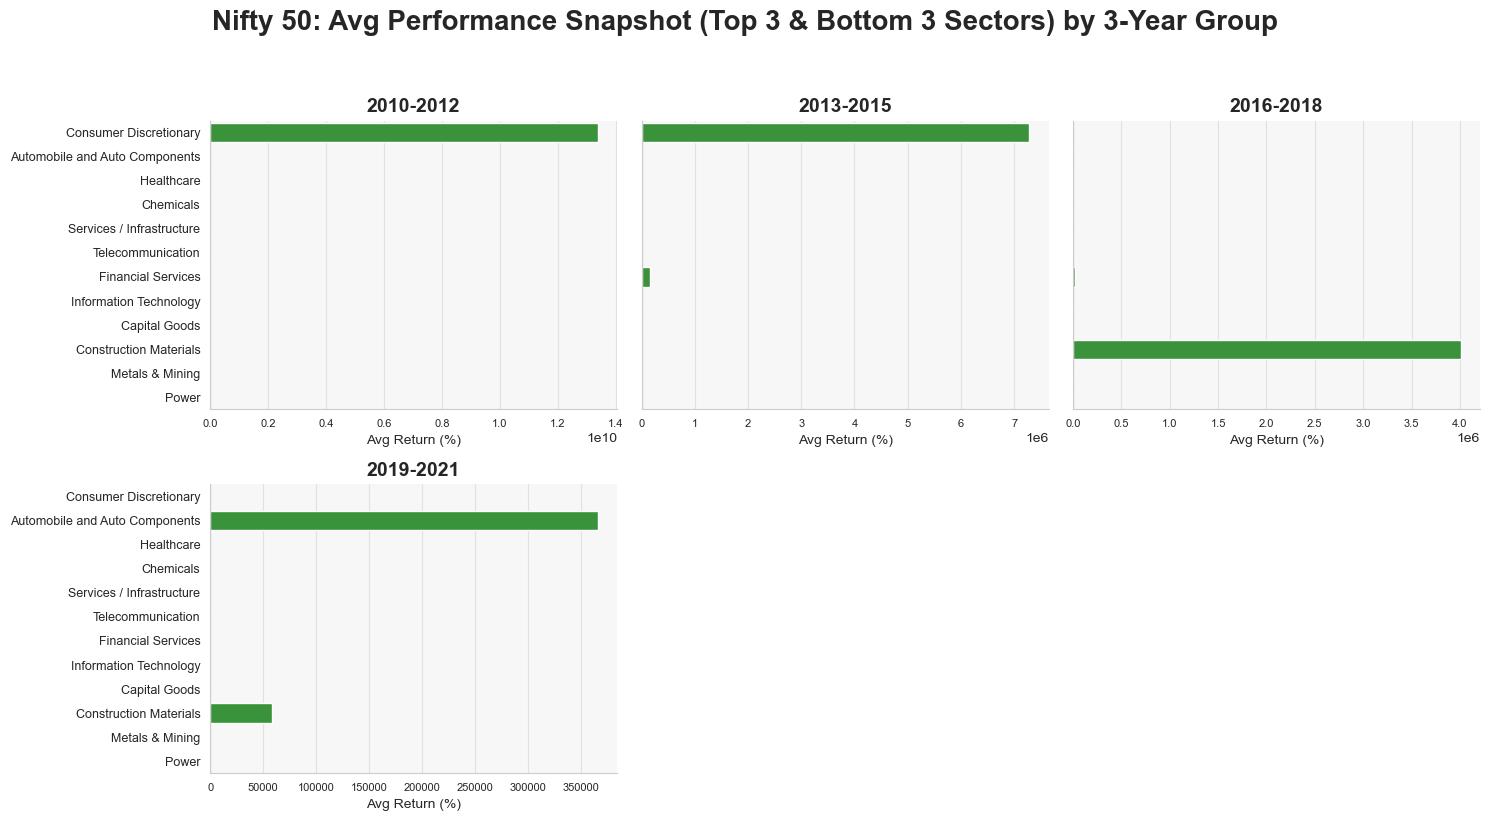

Nifty 50 Sector Growth Analysis charts generated and saved.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---
try:
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'Final-50-stocks.csv' is in the same directory as this script.")
    print("Please ensure the file is correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Define Sector Mapping ---
sector_mapping = {
    'TATASTEEL': 'Metals & Mining', 'WIPRO': 'Information Technology', 'TITAN': 'Consumer Discretionary',
    'ULTRACEMO': 'Construction Materials', 'TECHM': 'Information Technology', 'RELIANCE': 'Oil, Gas & Consumable Fuels',
    'SHREECEM': 'Construction Materials', 'SUNPHARMA': 'Healthcare', 'TATAMOTORS': 'Automobile and Auto Components',
    'TCS': 'Information Technology', 'SBIN': 'Financial Services', 'NESTLEIND': 'Fast Moving Consumer Goods',
    'NTPC': 'Power', 'M&M': 'Automobile and Auto Components', 'MARUTI': 'Automobile and Auto Components',
    'ONGC': 'Oil, Gas & Consumable Fuels', 'POWERGRID': 'Power', 'JSWSTEEL': 'Metals & Mining',
    'KOTAKBANK': 'Financial Services', 'LT': 'Capital Goods', 'ICICIBANK': 'Financial Services',
    'INDUSBANK': 'Financial Services', 'INFY': 'Information Technology', 'IOC': 'Oil, Gas & Consumable Fuels',
    'ITC': 'Fast Moving Consumer Goods', 'HEROMOTOCO': 'Automobile and Auto Components', 'HINDALCO': 'Metals & Mining',
    'HINDUNILVR': 'Fast Moving Consumer Goods', 'HCLTECH': 'Information Technology', 'HDFCBANK': 'Financial Services',
    'HDFC': 'Financial Services', 'DRREDDYS': 'Healthcare', 'EICHERMOTOR': 'Automobile and Auto Components',
    'GRASIM': 'Construction Materials', 'CIPLA': 'Healthcare', 'COALINDIA': 'Oil, Gas & Consumable Fuels',
    'BPCL': 'Oil, Gas & Consumable Fuels', 'BRITANNIA': 'Fast Moving Consumer Goods',
    'ADANIPORTS': 'Services / Infrastructure', 'BAJAJFINSERV': 'Financial Services',
    'BAJAJFINANCE': 'Financial Services', 'BHARTIARTL': 'Telecommunication', 'AXISBANK': 'Financial Services',
    'BAJAJ-AUTO': 'Automobile and Auto Components', 'ASIANPAINT': 'Consumer Discretionary', 'UPL': 'Chemicals'
}

# --- 3. Data Preprocessing and Sector Aggregation ---

nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df = nifty50_stocks_df.dropna(how='all', subset=stock_tickers)
# Add fill_method=None to suppress FutureWarning
stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change(fill_method=None)

stock_returns_melted = stock_returns_df.reset_index().melt(id_vars='Date', var_name='Stock', value_name='Daily_Return')
stock_returns_melted['Sector'] = stock_returns_melted['Stock'].map(sector_mapping)
stock_returns_melted = stock_returns_melted.dropna(subset=['Sector'])

sector_avg_daily_returns = stock_returns_melted.groupby(['Date', 'Sector'])['Daily_Return'].mean().unstack()
sector_avg_daily_returns = sector_avg_daily_returns.dropna(how='all')

# --- Calculate Annual Returns for Charts ---
# Use 'YE' for Year End and string "prod" for apply to suppress FutureWarning
annual_returns_sectors = (1 + sector_avg_daily_returns).resample('YE').apply("prod") - 1
annual_returns_sectors = annual_returns_sectors * 100 # Convert to percentage
annual_returns_sectors.index = annual_returns_sectors.index.year # Set index to just the year

# Fill NaNs with 0 for plotting (implies no return if data missing for a year)
annual_returns_sectors_filled = annual_returns_sectors.fillna(0)


# --- 4. Visualizations ---

# Set a stylish seaborn theme
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})

# Plot 1: Annual Sector Performance Snapshot: Top 3 & Bottom 3 (Grouped by 3 years)
num_top_bottom = 3 # Number of top/bottom sectors to show
group_size = 3 # Number of years to group together

all_years = annual_returns_sectors_filled.index.tolist()
year_groups = []
for i in range(0, len(all_years), group_size):
    year_groups.append(all_years[i:i + group_size])

# Determine grid size for subplots
num_cols_bar_chart = 3 # Let's keep 3 columns for better layout of 3-year groups
num_rows_bar_chart = int(np.ceil(len(year_groups) / num_cols_bar_chart))

fig1, axes1 = plt.subplots(num_rows_bar_chart, num_cols_bar_chart, figsize=(num_cols_bar_chart * 5, num_rows_bar_chart * 4), sharey=True)
axes1 = axes1.flatten()

for i, year_group in enumerate(year_groups):
    ax = axes1[i]
    
    # Calculate average annual return for each sector within this 3-year group
    group_start_year = year_group[0]
    group_end_year = year_group[-1]
    
    # Filter data for the current group of years
    group_data = annual_returns_sectors_filled.loc[group_start_year : group_end_year]
    
    # Calculate the average return for each sector across these years
    avg_group_returns = group_data.mean(axis=0).sort_values(ascending=False)
    
    # Get top N and bottom N sectors based on these average group returns
    top_n = avg_group_returns.head(num_top_bottom)
    bottom_n = avg_group_returns.tail(num_top_bottom)
    
    # Combine and sort for plotting
    plot_data = pd.concat([top_n, bottom_n]).reset_index()
    plot_data.columns = ['Sector', 'Average_Return']
    
    # Define colors: green for positive, red for negative
    colors = ['#2ca02c' if x > 0 else '#d62728' for x in plot_data['Average_Return']]

    sns.barplot(
        x='Average_Return',
        y='Sector',
        data=plot_data,
        palette=colors, # Use custom colors
        ax=ax
    )
    
    ax.set_title(f'{group_start_year}-{group_end_year}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Avg Return (%)', fontsize=10)
    ax.set_ylabel('') # Hide y-label for individual plots
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Zero line

# Remove any unused subplots
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])

plt.suptitle(f'Nifty 50: Avg Performance Snapshot (Top {num_top_bottom} & Bottom {num_top_bottom} Sectors) by {group_size}-Year Group', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f'nifty50_sectors_annual_top_bottom_bar_charts_grouped_by_{group_size}_years.png')
plt.show()
plt.close(fig1)

print("Nifty 50 Sector Growth Analysis charts generated and saved.")



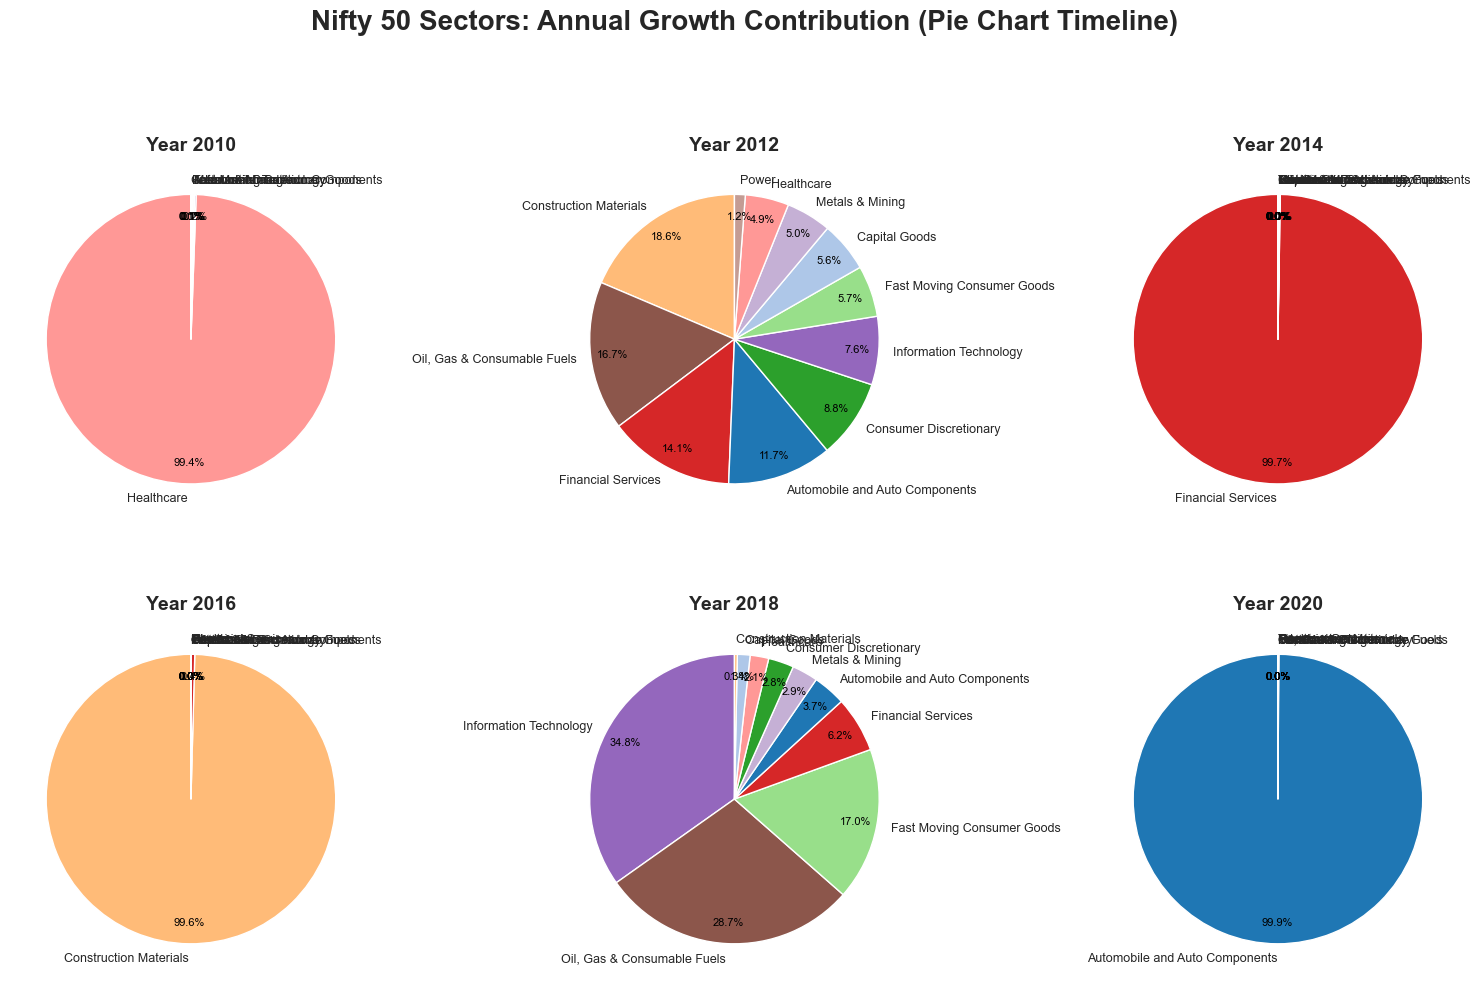

Nifty 50 Sector Growth Analysis charts generated and saved.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---
try:
    nifty50_stocks_df = pd.read_csv('Final-50-stocks.csv', parse_dates=['DATE'])
except FileNotFoundError:
    print("Error: Make sure 'Final-50-stocks.csv' is in the same directory as this script.")
    print("Please ensure the file is correctly uploaded or placed in the working directory.")
    exit()

# --- 2. Define Sector Mapping ---
sector_mapping = {
    'TATASTEEL': 'Metals & Mining', 'WIPRO': 'Information Technology', 'TITAN': 'Consumer Discretionary',
    'ULTRACEMO': 'Construction Materials', 'TECHM': 'Information Technology', 'RELIANCE': 'Oil, Gas & Consumable Fuels',
    'SHREECEM': 'Construction Materials', 'SUNPHARMA': 'Healthcare', 'TATAMOTORS': 'Automobile and Auto Components',
    'TCS': 'Information Technology', 'SBIN': 'Financial Services', 'NESTLEIND': 'Fast Moving Consumer Goods',
    'NTPC': 'Power', 'M&M': 'Automobile and Auto Components', 'MARUTI': 'Automobile and Auto Components',
    'ONGC': 'Oil, Gas & Consumable Fuels', 'POWERGRID': 'Power', 'JSWSTEEL': 'Metals & Mining',
    'KOTAKBANK': 'Financial Services', 'LT': 'Capital Goods', 'ICICIBANK': 'Financial Services',
    'INDUSBANK': 'Financial Services', 'INFY': 'Information Technology', 'IOC': 'Oil, Gas & Consumable Fuels',
    'ITC': 'Fast Moving Consumer Goods', 'HEROMOTOCO': 'Automobile and Auto Components', 'HINDALCO': 'Metals & Mining',
    'HINDUNILVR': 'Fast Moving Consumer Goods', 'HCLTECH': 'Information Technology', 'HDFCBANK': 'Financial Services',
    'HDFC': 'Financial Services', 'DRREDDYS': 'Healthcare', 'EICHERMOTOR': 'Automobile and Auto Components',
    'GRASIM': 'Construction Materials', 'CIPLA': 'Healthcare', 'COALINDIA': 'Oil, Gas & Consumable Fuels',
    'BPCL': 'Oil, Gas & Consumable Fuels', 'BRITANNIA': 'Fast Moving Consumer Goods',
    'ADANIPORTS': 'Services / Infrastructure', 'BAJAJFINSERV': 'Financial Services',
    'BAJAJFINANCE': 'Financial Services', 'BHARTIARTL': 'Telecommunication', 'AXISBANK': 'Financial Services',
    'BAJAJ-AUTO': 'Automobile and Auto Components', 'ASIANPAINT': 'Consumer Discretionary', 'UPL': 'Chemicals'
}

# --- 3. Data Preprocessing and Sector Aggregation ---

nifty50_stocks_df = nifty50_stocks_df.rename(columns={'DATE': 'Date'})
nifty50_stocks_df = nifty50_stocks_df.sort_values(by='Date').set_index('Date')

stock_tickers = nifty50_stocks_df.columns.tolist()
for col in stock_tickers:
    nifty50_stocks_df[col] = pd.to_numeric(nifty50_stocks_df[col], errors='coerce')

nifty50_stocks_df = nifty50_stocks_df.dropna(how='all', subset=stock_tickers)
# Add fill_method=None to suppress FutureWarning
stock_returns_df = nifty50_stocks_df[stock_tickers].pct_change(fill_method=None)

stock_returns_melted = stock_returns_df.reset_index().melt(id_vars='Date', var_name='Stock', value_name='Daily_Return')
stock_returns_melted['Sector'] = stock_returns_melted['Stock'].map(sector_mapping)
stock_returns_melted = stock_returns_melted.dropna(subset=['Sector'])

sector_avg_daily_returns = stock_returns_melted.groupby(['Date', 'Sector'])['Daily_Return'].mean().unstack()
sector_avg_daily_returns = sector_avg_daily_returns.dropna(how='all')

# --- Calculate Annual Returns for Charts ---
# Use 'YE' for Year End and string "prod" for apply to suppress FutureWarning
annual_returns_sectors = (1 + sector_avg_daily_returns).resample('YE').apply("prod") - 1
annual_returns_sectors = annual_returns_sectors * 100 # Convert to percentage
annual_returns_sectors.index = annual_returns_sectors.index.year # Set index to just the year

# Fill NaNs with 0 for plotting (implies no return if data missing for a year)
annual_returns_sectors_filled = annual_returns_sectors.fillna(0)


# --- 4. Visualizations ---

# Set a stylish seaborn theme
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 16,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'grid.color': '#cccccc', 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.edgecolor': '#cccccc'
})


# Plot 2: Sector Contribution Pie Chart Timeline
# Filter for years with positive overall market return to make pie charts meaningful (contribution to growth)
overall_nifty_annual_return = (1 + sector_avg_daily_returns.mean(axis=1)).resample('YE').apply("prod") - 1
overall_nifty_annual_return = overall_nifty_annual_return * 100
overall_nifty_annual_return.index = overall_nifty_annual_return.index.year

years_with_positive_overall_return = overall_nifty_annual_return[overall_nifty_annual_return > 0].index.tolist()

# --- CHANGE MADE HERE: Select a subset of years for pie charts ---
# For example, select every 2nd year, or specific milestone years
selected_pie_years = [year for i, year in enumerate(years_with_positive_overall_return) if i % 2 == 0] # Every other year
# Or you can manually select specific years: selected_pie_years = [2010, 2013, 2016, 2019, 2021]

num_cols_pie_chart = 3 # Adjusted number of columns for better layout
num_rows_pie_chart = int(np.ceil(len(selected_pie_years) / num_cols_pie_chart))

fig2, axes2 = plt.subplots(num_rows_pie_chart, num_cols_pie_chart, figsize=(num_cols_pie_chart * 5, num_rows_pie_chart * 5))
axes2 = axes2.flatten()

# Create a consistent color palette for all sectors across pie charts
all_sectors_for_pie = annual_returns_sectors_filled.columns.tolist()
pie_colors = sns.color_palette("tab20", n_colors=len(all_sectors_for_pie))
pie_color_map = dict(zip(all_sectors_for_pie, pie_colors))


for i, year in enumerate(selected_pie_years):
    ax = axes2[i]
    year_data = annual_returns_sectors_filled.loc[year]
    
    # Filter for positive contributions only for pie chart
    positive_contributions = year_data[year_data > 0]
    
    if not positive_contributions.empty:
        # Calculate percentage contribution to total positive return for the year
        total_positive_return = positive_contributions.sum()
        contributions_percent = (positive_contributions / total_positive_return) * 100
        
        # Sort for consistent pie chart appearance
        contributions_percent = contributions_percent.sort_values(ascending=False)

        # Get colors for the sectors present in this year's pie
        current_pie_colors = [pie_color_map[sector] for sector in contributions_percent.index]

        # Plot pie chart
        wedges, texts, autotexts = ax.pie(
            contributions_percent,
            labels=contributions_percent.index,
            autopct='%1.1f%%', # Show percentage on slices
            startangle=90,
            colors=current_pie_colors,
            pctdistance=0.85 # Distance of percentage labels from center
        )
        
        # Make percentage labels black for readability
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontsize(8)
        for text in texts:
            text.set_fontsize(9) # Adjust label font size

    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold')

# Remove any unused subplots
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.suptitle('Nifty 50 Sectors: Annual Growth Contribution (Pie Chart Timeline)', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('nifty50_sectors_annual_contribution_pie_charts.png')
plt.show()
plt.close(fig2)

print("Nifty 50 Sector Growth Analysis charts generated and saved.")
